### Промежуточный проект e-learning

Продакт-менеджер Василий попросил вас проанализировать завершенные уроки и ответить на следующие вопросы:

1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене) (7 баллов).

2. Выяви самый сложный и самый простой экзамены: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*. (5 баллов)

3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом). (5 баллов) 

4. Выяви самые популярные курсы (ТОП-3) по количеству регистраций на них. А также курсы с самым большим оттоком (ТОП-3). (8 баллов)

5. Напиши функцию на python, позволяющую строить когортный (семестровый) анализ. В период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов. (10 баллов) 

6. Построй адаптированные под задачу обучения RFM-кластеры студентов. Где R — среднее время сдачи одного экзамена, F — завершаемость курсов, M — среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Примерное описание подхода можно найти тут. (35 баллов)

*завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [86]:
# Взглянем на предложенные данные, проверим наличие пропусков и соответствие типов
assessments = pd.read_csv('assessments.csv')
courses = pd.read_csv('courses.csv')
studentAs = pd.read_csv('studentAssessment.csv')
studentReg = pd.read_csv('studentRegistration.csv')
# ... Выглядит неплохо, можно приступить к анализу

#### 1. Найдем, cколько студентов успешно сдали только один курс.

In [87]:
# Так как указано, что "Заключительные экзамены не принимаются, если результат предварительных тестов
# отсутствуют в системе", то к таблице с оценками учеников добавим колонку с предметом, типом работы и
# (на будущее) с кодом семестра, после чего оставим только результаты экзаменов.
as_need = assessments.loc[:, ['id_assessment','code_module','assessment_type','code_presentation']]

data = studentAs.merge(as_need, how='inner', on=['id_assessment'])

# И добавим в данные колонку о факте сдачи экзамена:
df = data.query("assessment_type == 'Exam'") \
         .assign(passed = data.score.apply(lambda x: 1 if x >= 40 else 0))

df.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,assessment_type,code_presentation,passed
52923,24290,558914,230,0,32.0,CCC,Exam,2014B,0
52924,24290,559706,234,0,78.0,CCC,Exam,2014B,1
52925,24290,559770,230,0,54.0,CCC,Exam,2014B,1
52926,24290,560114,230,0,64.0,CCC,Exam,2014B,1
52927,24290,560311,234,0,100.0,CCC,Exam,2014B,1


In [88]:
# Из нужных нам сейчас данных - cтудент, его оценка на экзамене по какому-то предмету:
# (и сразу оставим только сдавших)
df_1 = df.loc[:, ['id_student', 'score', 'code_module', 'assessment_type']][df.passed == 1]
df_1.head()

,id_student,score,code_module,assessment_type
52924,559706,78.0,CCC,Exam
52925,559770,54.0,CCC,Exam
52926,560114,64.0,CCC,Exam
52927,560311,100.0,CCC,Exam
52928,560494,92.0,CCC,Exam


In [89]:
# На всякий случай проверим, нет ли данных о дважды сданом экзамене одним учеником по одному
# и тому же предмету:
id_module_count = df_1.groupby(['id_student', 'code_module'], as_index=False) \
                      .agg({'assessment_type':'count'}) \
                      .rename(columns={'assessment_type': 'count_m'})
                      
id_module_count.query("count_m == 2")

,id_student,code_module,count_m
1341,540758,DDD,2
2232,593903,DDD,2
2479,605118,DDD,2


In [90]:
# Таких 3 человека - может оценку хотели исправить/перепроходили курс/есть какой-то баг в данных   
# Их нужно учитывать по одному разу, ведь они сдали только один курс(дважды один и тот же)
df.query("id_student in [605118, 593903, 540758]") \
  .sort_values('id_student') \
  .loc[:, ['id_student', 'date_submitted', 'score', 'code_module', 
           'assessment_type', 'code_presentation']]

,id_student,date_submitted,score,code_module,assessment_type,code_presentation
69983,540758,229,40.0,DDD,Exam,2013B
87573,540758,234,60.0,DDD,Exam,2014B
82731,593903,241,49.0,DDD,Exam,2013J
95711,593903,243,44.0,DDD,Exam,2014J
82844,605118,237,42.0,DDD,Exam,2013J
95749,605118,243,64.0,DDD,Exam,2014J


Теперь посчитаем количество студентов, которые успешно сдали один курс

In [91]:
# 1 способ - уже группированные по студентам и вариантам экзамена еще раз сгруппируем теперь уже 
# только по студентам считая количество различных экзаменов и  оставим студентов с одним экзаменом
id_module_count.groupby(['id_student'], as_index=False) \
               .agg({'code_module':'count'}) \
               .rename(columns={'code_module': 'count_ex'}) \
               .query("count_ex == 1") \
               .shape[0]

3805

In [92]:
# 2 способ для проверки - группировка по id_student и подсчет количества экзаменов на человека,
# где потом оставляем только людей успешно сдавших один экзамен + не забываем по веселую троицу
# которые успешно сдали один экзамен дважды
df_1.groupby(['id_student'], as_index=False) \
    .agg({'assessment_type':'count'}) \
    .query("assessment_type == 1") \
    .shape[0] + 3

3805

#### Ответ: успешно сдали только один курс 3805 студентов

P.S. Почему-то экзамен сдавали только по предметам ССС и DDD и то не всегда, странно, но ошибки при мердже вроде проверил и их нет. Может баг данных, а может студентам слишком сложно было учиться, очень-очень странно

In [93]:
# Нашел варианты id_assessment для всех возможных экзаменов
a = assessments[assessments.assessment_type == 'Exam'].id_assessment.values
# В studentAs нашел все зафиксированные проходившие экзамены 
b = studentAs.query('id_assessment in @a').id_assessment.unique() 
# Из всех возможных экзаменов данные в studentAs есть почему-то только про эти
assessments.query('id_assessment in @b')

,code_module,code_presentation,id_assessment,assessment_type,date,weight
62,CCC,2014B,24290,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
87,DDD,2013B,25340,Exam,240.0,100.0
94,DDD,2013J,25354,Exam,261.0,100.0
101,DDD,2014B,25361,Exam,241.0,100.0
108,DDD,2014J,25368,Exam,NaN,100.0


#### 2. Выяви самый сложный и самый простой экзамены: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*. (5 баллов)    
*завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

In [94]:
# Сгруппируем данные по курсам и посчитаем завершаемость
df_completion_p = df.groupby('code_presentation', as_index=False) \
        .agg({'passed': 'sum', 'id_student': 'count'}) \
        .rename(columns={'id_student': 'n_student'})
    
df_completion_p['completion'] = df_completion_p.passed / df_completion_p.n_student
df_completion_p = df_completion_p.sort_values('completion')

# Завершаемость по предметам
df_completion_m = df.groupby('code_module', as_index=False) \
        .agg({'passed': 'sum', 'id_student': 'count'}) \
        .rename(columns={'id_student': 'n_student'})
    
df_completion_m['completion'] = df_completion_m.passed / df_completion_m.n_student
df_completion_m = df_completion_m.sort_values('completion')

# Завершаемость по предметам в курсах:
df_completion_pm = df.groupby(['code_presentation', 'code_module'], as_index=False) \
        .agg({'passed': 'sum', 'id_student': 'count'}) \
        .rename(columns={'id_student': 'n_student'})
    
df_completion_pm['completion'] = df_completion_pm.passed / df_completion_pm.n_student
df_completion_pm = df_completion_pm.sort_values('completion')

# Посмотрим по таблице завершаемость:

# df_completion_p # по курсам
# df_completion_m # по предметам
df_completion_pm # по предметам в курсах
    

,code_presentation,code_module,passed,n_student,completion
0,2013B,DDD,504,602,0.837209
4,2014J,CCC,1019,1168,0.872432
5,2014J,DDD,842,950,0.886316
2,2014B,CCC,664,747,0.888889
1,2013J,DDD,878,968,0.907025
3,2014B,DDD,485,524,0.925573


#### Ответ: Думаю, что самым простым был DDD в курсе 2014B(самая большая завершаемость) и самым сложным DDD в курсе 2013В(самая низкая завершаемость)

#### 3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом). (5 баллов) 

In [95]:
# Определим средний срок сдачи экзаменов на различных курсах со старта семестра
df[df.passed == 1].groupby(['code_presentation', 'code_module'], as_index=False) \
                  .agg({'date_submitted': 'mean'})

# Определим средний срок сдачи различных экзаменов со старта семестра
# df[df.passed == 1].groupby(['code_module'], as_index=False) \
#                   .agg({'date_submitted': 'mean'})

,code_presentation,code_module,date_submitted
0,2013B,DDD,230.164683
1,2013J,DDD,239.509112
2,2014B,CCC,231.581325
3,2014B,DDD,234.936082
4,2014J,CCC,244.404318
5,2014J,DDD,242.804038


#### 4. Выяви самые популярные курсы (ТОП-3) по количеству регистраций на них. А также курсы с самым большим оттоком (ТОП-3). (8 баллов)

Есть некоторая странность в данных - у некоторых студентов отсутвует дата регистрации. Тогда буду считать так: 
1. У студентов с NaN датой регистрации и не NaN датой отмены регистрации просто не записалось значение даты регистрации - включаю их в подсчет регистрации и оттока
2.  У студентов с NaN датой регистрации и NaN датой отмены регистрации сломались оба счетчика - в привед. ниже коде видно, что они не выполняли заданий, но раз появились, то видимо система пыталась записать их регистарцию, но не вышло :(,  включаю их в подсчет регистрации и оттока

In [96]:
q = studentReg[(studentReg.date_registration.isna()) & 
               (studentReg.date_unregistration.isna())].id_student.values
data.query("id_student in @q").shape[0] # смотрю делали ли какие-то задания эти студенты

0

In [97]:
# Найдем самые популярные курсы (ТОП-3) по количеству регистраций(с повторениями)
studentReg.groupby('code_module', as_index=False) \
          .agg({'id_student': 'count'}) \
          .rename(columns={'id_student': 'n_students_reg'}) \
          .sort_values('n_students_reg', ascending=False).head(3)

,code_module,n_students_reg
1,BBB,7909
5,FFF,7762
3,DDD,6272


In [98]:
# Найдем самые популярные курсы (ТОП-3) по количеству регистраций(с уникальными пользователями)
pd.DataFrame(studentReg.groupby('code_module', as_index=False).id_student.nunique())\
                       .rename(columns={'id_student': 'n_students_reg_u'}) \
                       .sort_values('n_students_reg_u', ascending=False).head(3)

,code_module,n_students_reg_u
1,BBB,7692
5,FFF,7397
3,DDD,5848


In [99]:
# Найдем самые популярные курсы (ТОП-3) по количеству оттока(с повторениями)

# Теперь с учетом странности в статистику оттока курса попадают все студенты, кроме тех у которых 
# есть дата регистрации и нет даты отмены регистрации

q = studentReg[(studentReg.date_registration.isna() == False) &
              (studentReg.date_unregistration.isna())].id_student.values
studentReg.query('id_student not in @q') \
          .groupby('code_module', as_index=False).agg({'id_student': 'count'}) \
          .rename(columns={'id_student': 'n_student_out'}) \
          .sort_values('n_student_out', ascending=False).head(3)

,code_module,n_student_out
1,BBB,2215
5,FFF,2137
3,DDD,1943


In [100]:
# Найдем самые популярные курсы (ТОП-3) по количеству оттока(с уникальными пользователями)

# Теперь с учетом странности в статистику оттока курса можно ключить тех студентов, количество отмен
# регистраций которых >= количеству регистраций на соответствующий курс

studentReg \
    .groupby(['id_student', 'code_module'], as_index=False) \
    .agg({'date_registration': 'count', 'date_unregistration': 'count'}) \
    .query('date_unregistration >= date_registration') \
    .groupby('code_module', as_index=False).agg({'id_student': 'count'}) \
    .rename(columns={'id_student': 'n_student_out_u'}) \
    .sort_values('n_student_out_u', ascending=False).head(3)

,code_module,n_student_out_u
1,BBB,2181
5,FFF,2043
3,DDD,1843


#### Ответ: самые популярные и одновременно же и курсы с самым большим оттоком это ВВВ, FFF, DDD.

#### 5. Напиши функцию на python, позволяющую строить когортный (семестровый) анализ. В период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов. (10 баллов) 

In [101]:
# Сроки сдачи экзаменов варьируются в пределах от 229 до 285 дней от начала семестра
df.date_submitted.describe()

count    4959.000000
mean      238.483565
std         5.717577
min       229.000000
25%       234.000000
50%       241.000000
75%       243.000000
max       285.000000
Name: date_submitted, dtype: float64

In [102]:
# Функция для поиска завершаемости(из п. 2) при установ. временном промежутке
def completion(df, index='code_presentation',
        columns='date_submitted', id_student='id_student', passed='passed'):
   
    df_i = df.groupby(index, as_index=False) \
             .agg({passed: 'sum', id_student: 'count'})

    df_i['completion'] = df_i.passed / df_i.id_student
    df_i = df_i.sort_values('code_presentation')
#   Возвращает массив завершонностей и массив с названиями семестров
    return df_i.completion.values, df_i.code_presentation.values


# Функция для когортного анализа
def cog(df, index='code_presentation',
        columns='date_submitted', id_student='id_student', passed='passed'):
    
# Создадим освнову для таблицы
    df_i = df.query(' 0 <= date_submitted <= 230')
    com, sem = completion(df_i)
    table = pd.DataFrame({f'{230} день': com}, index=sem)
    
# Запустим цикл для разных промежутков времени
    for i in range(240, 300, 10):
        df_i = df.query(' 230 <= date_submitted <= @i')
        com, sem = completion(df_i)
        table_i = pd.DataFrame({f'{i} день': com}, index=sem)
        table = pd.concat([table, table_i], axis=1)
    return table

In [103]:
# Получим искомую таблицу и проанализируем результат
cog(df)

,230 день,240 день,250 день,260 день,270 день,280 день,290 день
2013B,0.835322,0.840095,0.839243,0.839243,0.839243,0.839243,0.839243
2014B,0.898129,0.904348,0.903861,0.903937,0.904013,0.904013,0.904013
2013J,NaN,0.908889,0.906929,0.907025,0.907025,0.907025,0.907025
2014J,NaN,NaN,0.878687,0.878544,0.878544,0.878602,0.878659


#### Cмотря на таблицу наглядно видим, что семестр с самой низкой завершаемостью курсов - это семестр 2013B(даже в последнем временном промежутке завершенность все еще самая низкая и заметно отличается от друих), а с самыми долгими средними сроками сдачи курсов - 2014J(в первые 2 промежутка никто вообще не успел сдать экзамен, тут студенты начали заментно позже

#### 6. Построй адаптированные под задачу обучения RFM-кластеры студентов. Где R — среднее время сдачи одного экзамена, F — завершаемость курсов, M — среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Примерное описание подхода можно найти тут. (35 баллов)

In [104]:
# Выделим нужные кластеры:
# Если R среднее время сдачи экзаменов(Как быстро сдал экз) - то определим 3 выозможных занчения - 
# Быстро сдал экзамен, среднее время сдачи, долгое время сдачи + аналогично для F и M:

rfm_table = pd.DataFrame({'R: Как быстро сдали': ['1 - Медленно', '2 - Средне', '3 - Быстро'], 
                          'F: Завершаемость': ['1 - Низкая', '2 - Средняя', '3 - Высокая'], 
                          'M: Среднее кол-во баллов': ['1 - Низкое', '2 - Среднее', '3 - Высокое']})
rfm_table

,R: Как быстро сдали,F: Завершаемость,M: Среднее кол-во баллов
0,1 - Медленно,1 - Низкая,1 - Низкое
1,2 - Средне,2 - Средняя,2 - Среднее
2,3 - Быстро,3 - Высокая,3 - Высокое


In [105]:
# Выберем данные студентов о сдаче экзаменов:
df_rfm = df.loc[:, ['id_student', 'date_submitted', 'passed', 'score']]
# Посчитаем R F M для каждого студента
df_rfm = df_rfm.groupby('id_student', as_index=False) \
      .agg({'date_submitted': 'mean', 'passed': 'mean', 'score': 'mean' })

df_rfm.head()

,id_student,date_submitted,passed,score
0,23698,243.0,1.0,80.0
1,24213,236.0,1.0,58.0
2,27116,243.0,1.0,96.0
3,28046,237.0,1.0,40.0
4,28787,243.0,1.0,44.0


In [106]:
# Разделение на 3 группы в каждом кластере можно устроить просто: ранижировать по значению 
# и делить на 3 равные по объему группы или же установить пороги в занчениях 33 и 66 перцентилей для
# соответствующих значений, но мне кажется более уместным разделить студентов так:
# взглянем на распределения сответ. значений у студентов:

df_rfm.describe()
# Определим для R разделение: 
#  3 - 1кв, 2 - 2кв и 3кв, 1 - 4кв (в нашем примере те кто сдал в течение 5 дней после самого 
# быстрого тоже быстрые, потом идут средние - почти в два раза больше промежуток 9 дней, а все 
# остальные становятся медленными)

# Разделение для F проще: 3 - кто сдал все(или почти) экзамены на которые ходил - [0.8, 1] 
# 2 - кто сдал половину или большинство экзаменов [0.5, 0.8) (не так много данных и возможны значения
# пока только 0, 0.5 и 1), 1 - кто не сдал большинство экзаменов - [0, 0.5)

# Разделение на M: эвристический подход, близкий к 5 бальной системе(и к разделению на квартили тоже)
# 3 - от 80(что-то вроде отличников), 2 - от 50 до 80(средние ученики),
# 1 - меньше 50(имеющие большее количетсво недочетов - не сдавшие/ чудом сдавшие экзамен(ы))

,id_student,date_submitted,passed,score
count,4.633000e+03,4633.000000,4633.000000,4633.000000
mean,7.256904e+05,238.462227,0.881286,65.117958
std,5.753498e+05,5.653378,0.321142,20.470561
min,2.369800e+04,229.000000,0.000000,0.000000
25%,5.011580e+05,234.000000,1.000000,50.000000
50%,5.884820e+05,241.000000,1.000000,66.000000
75%,6.463510e+05,243.000000,1.000000,82.000000
max,2.698251e+06,285.000000,1.000000,100.000000


In [107]:
# Ф-я для выбора значения кластера
def choici(x, bord):
    if x < bord[0]: return 1
    elif x >= bord[1]: return 3
    else: return 2
    
def choici_r(x, bord):
    if x > bord[1]: return 1
    elif x <= bord[0]: return 3
    else: return 2
    
# Ф-я для деления на кластеры
def rfm_cut(df, id='id_student', r='date_submitted', f='passed', m='score'):
    df_rfm = df.loc[:, [id, r, f, m]]
#     Укажем границы
    r_s = df_rfm[r].quantile(q=[0.25, 0.75]).values
    f_s = (0.5, 0.8)
    m_s = (50, 80)
#     Присвоим нужные значения из кластеров всем студентам:
    df_rfm[r] = df_rfm[r].apply(lambda x: choici_r(x, r_s))
    df_rfm[f] = df_rfm[f].apply(lambda x: choici(x, f_s))
    df_rfm[m] = df_rfm[m].apply(lambda x: choici(x, m_s))
    
    return df_rfm.rename(columns={'date_submitted':'R','passed':'F','score':'M' })

In [108]:
df_rfm.loc[:, ['id_student', 'score']]

,id_student,score
0,23698,80.0
1,24213,58.0
2,27116,96.0
3,28046,40.0
4,28787,44.0
...,...,...
4628,2694886,69.0
4629,2694933,73.0
4630,2695608,73.0
4631,2697181,80.0


In [109]:
rfm_t = rfm_cut(df_rfm) 
# Теперь можно по-разному разделить студентов на разное количество групп и использовать их для
# всевозможного анализа или таргетинга или другой миллион вариантов

# Посмотрим на какие группы делит данные RFM анализ
rfm_t['typi_1'] = rfm_t[rfm_t.columns[1:4]].apply(lambda x: sum(x), axis=1)

rfm_t['typi_2'] = rfm_t[rfm_t.columns[1:4]].apply(lambda x: ''.join(x.astype(str)), axis=1)

rfm_t = rfm_t.merge(df_rfm.loc[:, ['id_student', 'score']], how='left', on=['id_student', ]) # добавим колонку с оценками

rfm_t.head()

,id_student,R,F,M,typi_1,typi_2,score
0,23698,2,3,3,8,233,80.0
1,24213,2,3,2,7,232,58.0
2,27116,2,3,3,8,233,96.0
3,28046,2,3,1,6,231,40.0
4,28787,2,3,1,6,231,44.0


In [110]:
# Можно посмтореть на все возможные варианты сочетаний (у нас их возможно 3^3, а присутвует в данных
# только 17

rfm_t.groupby('typi_2', as_index=False).agg({'id_student': 'count'}).head()

,typi_2,id_student
0,111,117
1,121,1
2,131,109
3,132,367
4,133,346


In [111]:
# Можно ограничиться одним признаком, например, сложить и вывести общюю "крутость" студента
# как сумму "очков по 3 RFM категориям" - чем больше, тем студент суммарно быстрее(сдает)/
# выше(средний балл имеет)/сильнее(имеет лучшую завершаемость)

rfm_t.groupby('typi_1', as_index=False).agg({'id_student': 'count'}).rename(columns={'id_student': 'count_st'})

,typi_1,count_st
0,3,117
1,4,241
2,5,300
3,6,649
4,7,1684
5,8,1241
6,9,401


In [112]:
#Посмотрим на количество людей в разных кластерах 
pd.crosstab(index = rfm_t.R, columns = rfm_t.F)

F,1,2,3
R,,,
1,117,1,822
2,240,18,1953
3,179,9,1294


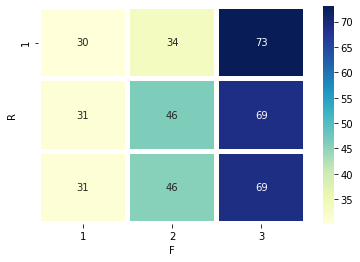

In [113]:
# Посмотрим на распределение средних оценок за курс по различным кластерам
rfm_t_plot = rfm_t.pivot_table(index='R', 
                  columns='F', 
                  values='score', 
                  aggfunc=np.mean)
sns.heatmap(rfm_t_plot, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4);